In [1]:

import numpy as np


import re
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, LSTM, Input, Embedding,GRU
from keras.models import Sequential

from keras.utils import np_utils,Sequence
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import time,os


In [2]:






file = open("/content/drive/MyDrive/466data/en_tech_train.txt", "rb")
train_set = file.read().decode(encoding='utf-8')


In [3]:
processed_train_set = train_set.split("\n")



In [4]:
with open("/content/drive/MyDrive/parameters"+"/1.h5","w") as obj:
    obj.write("new")

In [5]:
train = True

In [6]:


def produce_training_xy(processed_train_set, maxlen):
    training_sentences = []
    for each_line in processed_train_set:       
        split_line = [i for i in each_line.split(" ") if i]
        length = len(split_line)
        if length >= maxlen: 
            for each_word_index in range(length-maxlen+1):
                seq = split_line[each_word_index:each_word_index+maxlen]
                line = " ".join(seq)
                training_sentences.append(line)  

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(training_sentences)

    sequences = np.array(tokenizer.texts_to_sequences(training_sentences))

    vocab_size = len(tokenizer.word_index) + 1

    return sequences[:, :-1], to_categorical(sequences[:, -1], num_classes = vocab_size), vocab_size

In [7]:
def load_weights_to_model(vocab_size, each_input_length, lstm_unit_num, dropout_rate, dense_unit_num, epoch):
    name = "rnn_weights_%d_%.2f_%d_%d_%d.h5"%(lstm_unit_num, dropout_rate, dense_unit_num,epoch,each_input_length)
    model = Sequential()
    model.add(Embedding(vocab_size, 256))
    model.add(LSTM(lstm_unit_num))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_unit_num, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    full_path = "/content/drive/MyDrive/parameters/"+name
    if os.path.isfile(full_path):
        model.load_weights(full_path)
    model.summary()
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
def get_vocab_size(processed_train_set,each_input_length):
    training_sentences = []
    for each_line in processed_train_set:       
        split_line = [i for i in each_line.split(" ") if i]
        length = len(split_line)
        if length >= each_input_length: 
            for each_word_index in range(length-each_input_length+1):
                seq = split_line[each_word_index:each_word_index+each_input_length]
                line = " ".join(seq)
                training_sentences.append(line)  
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(training_sentences)

    sequences = np.array(tokenizer.texts_to_sequences(training_sentences))

    return len(tokenizer.word_index) + 1, tokenizer

def training_with_parameters(X, y, vocab_size, each_input_length, lstm_unit_num, dropout_rate, dense_unit_num, epoch):
    name = "rnn_weights_%d_%.2f_%d_%d_%d.h5"%(lstm_unit_num, dropout_rate, dense_unit_num,epoch,each_input_length)
    

    # Define our language model:
    model = Sequential()
    model.add(Embedding(vocab_size, 256))
    model.add(LSTM(lstm_unit_num))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_unit_num, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    full_path = "/content/drive/MyDrive/parameters/"+name
    if os.path.isfile(full_path):
        model.load_weights(full_path)
    model.summary()
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    
    print("%s cache saved"%(name))
    checkpoint = ModelCheckpoint(name, 
                                monitor='loss', 
                                verbose=1,
                                save_best_only=True,
                                mode='min')
    callbacks_list = [checkpoint]
    model.fit(X,y, batch_size=256, epochs=epoch, callbacks=callbacks_list)
    
    model.save_weights(name)
    return model

In [8]:

# Hyperparameters that needs to be tuned.
if train:
    input_length = [ 20]
    lstm_unit_num = [256, 512, 1024]
    dense_unit_num = [256]
    dropout_rate = [0.2]
    epochs = [40]
    model_collection = [] # A list of lists, each sub list has the form [model Object, input_length, lstm_unit_num, dropout_rate, dense_unit_num,epoche]
    for epo in epochs:
        for each_input_length in input_length:

            training_sentences = []
            for each_line in processed_train_set:       
                split_line = [i for i in each_line.split(" ") if i]
                length = len(split_line)
                if length >= each_input_length: 
                    for each_word_index in range(length-each_input_length+1):
                        seq = split_line[each_word_index:each_word_index+each_input_length]
                        line = " ".join(seq)
                        training_sentences.append(line)  

            tokenizer = Tokenizer()
            tokenizer.fit_on_texts(training_sentences)

            sequences = np.array(tokenizer.texts_to_sequences(training_sentences))

            vocab_size = len(tokenizer.word_index) + 1
            X,y = sequences[:, :-1], sequences[:, -1]
            y = to_categorical(y, num_classes = vocab_size)

            for each_lstm_unit_num in lstm_unit_num:
                for each_dense_unit_num in dense_unit_num:
                    for each_dropout_rate in dropout_rate:
                
                        #model = training_with_parameters(X, y, vocab_size, each_input_length, each_lstm_unit_num, each_dropout_rate, each_dense_unit_num, epo)
                        name = "rnn_weights_%d_%.2f_%d_%d_%d.h5"%(each_lstm_unit_num, each_dropout_rate, each_dense_unit_num,epo,each_input_length)
    

                        # Define our language model:
                        model = Sequential()
                        model.add(Embedding(vocab_size, 256))
                        model.add(LSTM(each_lstm_unit_num))
                        model.add(Dropout(each_dropout_rate))
                        model.add(Dense(each_dense_unit_num, activation='relu'))
                        model.add(Dense(vocab_size, activation='softmax'))
                        full_path = "/content/drive/MyDrive/parameters/"+name
                        if os.path.isfile(full_path):
                            model.load_weights(full_path)
                        model.summary()
                        model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

                        
                        print("%s cache saved"%(full_path))
                        checkpoint = ModelCheckpoint(full_path, 
                                                    monitor='loss', 
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='min')
                        callbacks_list = [checkpoint]
                        model.fit(X,y, batch_size=256, epochs=epo, callbacks=callbacks_list)
                        
                        model.save_weights(full_path)
                        model_collection.append([model, each_input_length, each_lstm_unit_num, each_dropout_rate, each_dense_unit_num, epo])




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         4656128   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 18188)             4674316   
Total params: 9,921,548
Trainable params: 9,921,548
Non-trainable params: 0
_________________________________________________________________
/content/drive/MyDrive/parameters/rnn_weights_256_0.20_256_40_20.h5 cache saved
Epoch 1/40
235/235 [============

In [11]:
!python -m spacy download en_core_web_lg
!pip3 install -U spacy
import spacy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from spacy.lang.en.examples import sentences 


2021-04-05 20:38:44.570147: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 778.8MB 23kB/s 
  Found existing installation: en-core-web-lg 2.2.5
    Uninstalling en-core-web-lg-2.2.5:
      Successfully uninstalled en-core-web-lg-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.5)


In [12]:



nlp = spacy.load('en_core_web_lg')

In [13]:
file = open("/content/drive/MyDrive/466data/en_tech_test.txt", "rb")
test_set = file.read().decode(encoding='utf-8')
file = open("/content/drive/MyDrive/466data/en_tech_validate.txt", "rb")
validate_set = file.read().decode(encoding='utf-8')
processed_test_set = test_set.split("\n")
processed_validate_set = validate_set.split("\n")

In [14]:
def predict_single(model, tokenizer, seed_text,maxlength):
    
    predicted_word = None
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
    encoded = pad_sequences([encoded], maxlen = maxlength-1, truncating='pre')

    temp = model.predict(encoded)

    y_predict = np.argmax(temp, axis=-1)

    for word, index in tokenizer.word_index.items():
        if index == y_predict:
            predicted_word = word
            break
    return str(predicted_word)

def validate(validate_sentences, nlp, model,tokenizer,input_size):
  new = []
  for i in range(len(validate_sentences)):
      new.append(validate_sentences[i].split())
  validate_sequences = np.array(new)
  validate_X, validate_y = validate_sequences[:, :-1], validate_sequences[:, -1]
  average_accuracy = 0
  num = 0
  for i in range(len(validate_X)):
      if i%200==0:
          print(i)
      prediction = predict_single(model, tokenizer, ' '.join(validate_X[i]),input_size)
      x = nlp(prediction)
      y = nlp(str(validate_y[i]))

      if (x[0].has_vector) and (y[0].has_vector):
          average_accuracy += nlp(prediction).similarity(nlp(str(validate_y[i])))
          num += 1

  average_accuracy /= num
  return average_accuracy

In [15]:

input_length = [5, 20]
lstm_unit_num = [256, 512, 1024]
dense_unit_num = 256
dropout_rate = 0.2
epoch = 40
model_list = []
tokenizer = None
for i in lstm_unit_num:
    for j in input_length:
        vocab_size,tokenizer = get_vocab_size(processed_train_set,j)  
        #vocab_size, each_input_length, lstm_unit_num, dropout_rate, dense_unit_num, epoch   
        model = load_weights_to_model(vocab_size, j, i, dropout_rate, dense_unit_num, epoch)
        

        # validation
        validate_sentences = []
        input_size = j
        for line in processed_validate_set:
            temp = line.split()
            for index in range(input_size, len(temp)):
                seq = temp[index - input_size:index]
                temp2 = " ".join(seq)
                validate_sentences.append(temp2)
        
        accuracy = validate(validate_sentences, nlp, model,tokenizer,j)
        print("LSTM %d, Input_length %d finished, accuracy %.3f"%(i,j,accuracy))
        model_list.append([model,vocab_size, j, i, dropout_rate, dense_unit_num, epoch, accuracy])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 256)         5668352   
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 22142)             5690494   
Total params: 11,949,950
Trainable params: 11,949,950
Non-trainable params: 0
_________________________________________________________________
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400


In [16]:
max_value = 0
max_index = 0
for i in range(len(model_list)):
    if model_list[i][-1]>max_value:
        max_value = model_list[i][-1]
        max_index = model_list[i]

In [17]:
import matplotlib.pyplot as plt

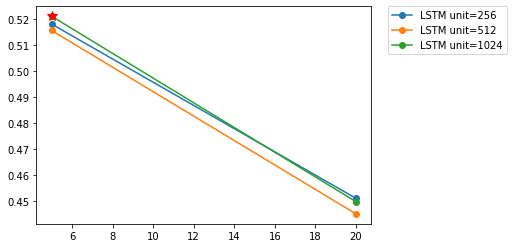

In [18]:
#vocab_size, each_input_length, lstm_unit_num, dropout_rate, dense_unit_num, epoch   
for k in [256,512,1024]:
    temp_list = [(i[2],i[-1]) for i in model_list if i[3] == k]
    plt.plot([i[0] for i in temp_list],[i[1] for i in temp_list],'o-',label="LSTM unit=%d"%k)
    #plt.legend(str(k))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot(max_index[2], max_index[-1], 'r*',markersize=10)

In [19]:
model = load_weights_to_model(22142, 5, 1024, dropout_rate, dense_unit_num, epoch)

#name = "rnn_weights_%d_%.2f_%d_%d_%d.h5"%(each_lstm_unit_num, each_dropout_rate, each_dense_unit_num,epo,each_input_length)
accuracy_list = []
for input_size in [2,3,5,10,20]:
    test_sentences = []
    for line in processed_test_set:
        #print("line",line)
        temp = line.split(' ')
        #print("temp",temp)
        if input_size<=len(temp):
            for i in range(input_size, len(temp)):
                #print("i",i)
                #print("input_size",input_size)
                seq = temp[i - input_size:i]
                #print("sep",seq)
                temp2 = " ".join(seq)
                test_sentences.append(temp2)
                #print("test",test_sentences)
                #assert 1==2,'stop'
    #print(test_sentences[0:20])
    #print(len(test_sentences))
    new = []
    
    #print(len(test_sentences))
    for i in range(len(test_sentences)):
        if i%5==0:
            
            new.append(test_sentences[i].split())
    print("new",new[0:2])
    print(new[0][0])
    test_seq = new

    test_X, test_y = [i[0:-1] for i in test_seq], [i[-1] for i in test_seq]
    print(test_X[0:10])
    print(test_seq[:][1])
    average_accuracy = 0
    num = 0
    for i in range(len(test_X)):
        prediction = predict_single(model, tokenizer, ' '.join(test_X[i]),input_size)
        if i%200==0:
            print(i)
        x = nlp(prediction)
        y = nlp(str(test_y[i]))

        if (x[0].has_vector) and (y[0].has_vector):
            average_accuracy += nlp(prediction).similarity(nlp(str(test_y[i])))
            num += 1  
    average_accuracy /= num
    accuracy_list.append((input_size,average_accuracy))
print(accuracy_list)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 256)         5668352   
_________________________________________________________________
lstm_9 (LSTM)                (None, 1024)              5246976   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_19 (Dense)             (None, 22142)             5690494   
Total params: 16,868,222
Trainable params: 16,868,222
Non-trainable params: 0
_________________________________________________________________
new [['merle', 'kilgore'], ['country', 'hit']]
merle
[['merle'], ['country'], ['has'], ['failure'], ['a'], [

Text(0, 0.5, 'average similarity')

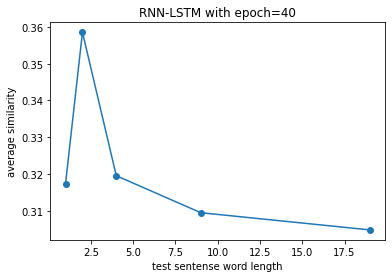

In [21]:
x = [i[0]-1 for i in accuracy_list]
y = [i[1] for i in accuracy_list]
plt.plot(x,y,'o-')
plt.title("RNN-LSTM with epoch=40")
plt.xlabel("test sentense word length")
plt.ylabel("average similarity")